# SBM Classification

In [24]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import gc
import math
import pandas as pd
import numpy as np
import time, multiprocessing
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm import tqdm
import seaborn as sns
from pathlib import Path

import rerf
from rerf.rerfClassifier import rerfClassifier
from graspy.plot import heatmap

from scipy.stats import bernoulli
from scipy import stats

from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from utils.load_Xy import load_sbms_Xy, load_graphsignal_Xy
from utils.utils import plot_data

gc.enable()

import warnings
warnings.simplefilter('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
save_dir = Path('sbms')

In [18]:
ns = np.array([10,50,100,200])#,400,1000,2000])

n_train = max(ns)
n_test = 10000
communities1 = [30,30]
#communities2 = [30,30]
communities2 = [20,20,20]
p1 = [[0.3,0.1],[0.1,0.3]]
#p2 = [[0.1,0.3],[0.3,0.1]]
assocp = (30**2*0.3*2 + 30**2*0.1*2 - 20**2*0.3*3) / (20**2*6)
p2 = [[0.3,assocp,assocp],[assocp,0.3,assocp],[assocp,assocp,0.3]]
X_train,y_train,_ = load_sbms_Xy(int(n_train/2),int(n_train/2),communities1,communities2,p1,p2,ns,seed=1)
X_test,y_test,size_dict = load_sbms_Xy(int(n_test/2),int(n_test/2),communities1,communities2,p1,p2,seed=0)

In [40]:
ns = np.array([10,50,100,200])#,400,1000,2000])

n_train = max(ns)
n_test = 10000

X_train,y_train,_ = load_graphsignal_Xy(int(n_train/2),int(n_train/2),ns)
X_test,y_test,size_dict = load_graphsignal_Xy(int(n_test/2),int(n_test/2),ns)

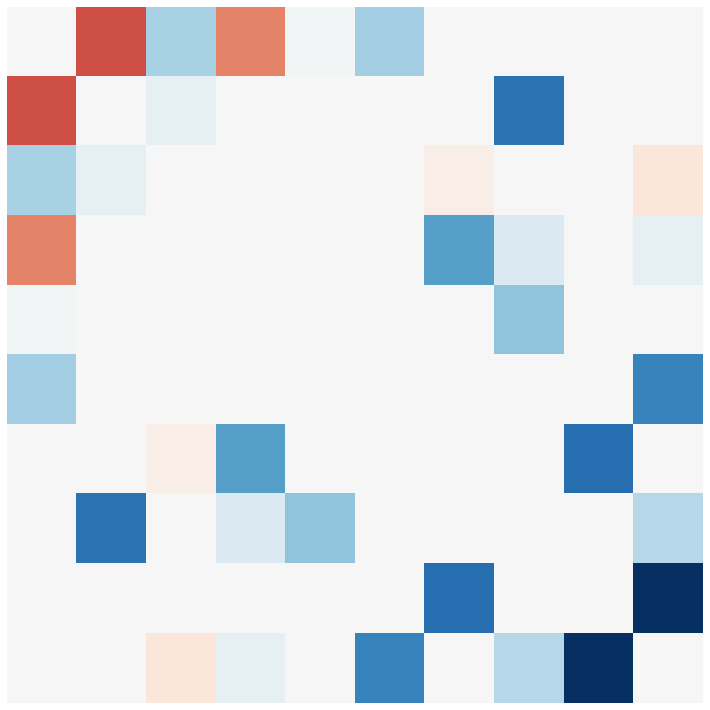

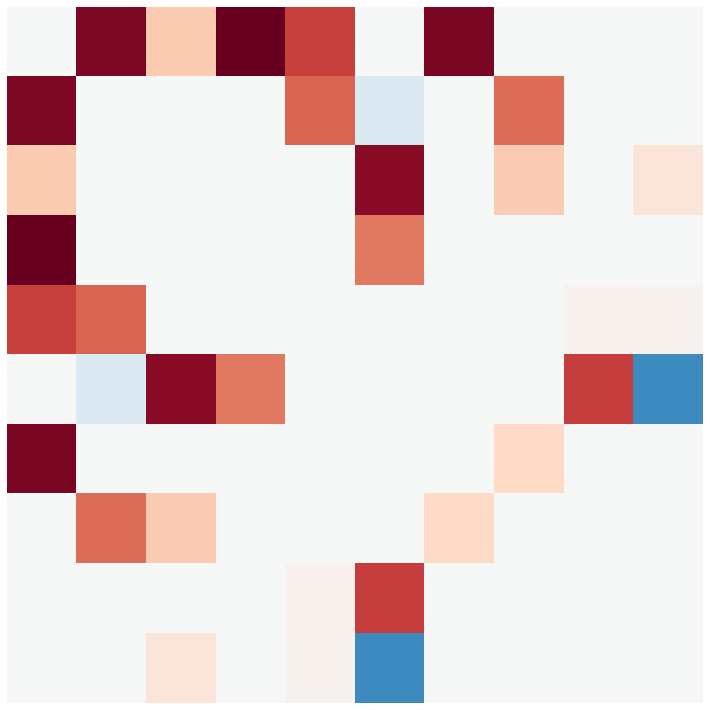

In [41]:
# heatmap(X_train[np.where(y_train == 0)[0][0]].reshape(sum(communities1), -1),inner_hier_labels=[1]*30+[2]*30,cbar=False)
# plt.tight_layout()
# plt.savefig(save_dir / 'sbms_heatmap_class0_ex1.pdf')
# heatmap(X_train[np.where(y_train == 0)[0][1]].reshape(sum(communities1), -1),inner_hier_labels=[1]*30+[2]*30,cbar=False)
# plt.tight_layout()
# plt.savefig(save_dir / 'sbms_heatmap_class0_ex2.pdf')

# heatmap(X_train[np.where(y_train == 1)[0][0]].reshape(sum(communities1), -1),inner_hier_labels=[1]*20+[2]*20+[3]*20,cbar=False)
# plt.tight_layout()
# plt.savefig(save_dir / 'sbms_heatmap_class1_ex1.pdf')
# heatmap(X_train[np.where(y_train == 1)[0][1]].reshape(sum(communities1), -1),inner_hier_labels=[1]*20+[2]*20+[3]*20,cbar=False)
# plt.tight_layout()
# plt.savefig(save_dir / 'sbms_heatmap_class1_ex2.pdf')
n_nodes = np.sqrt(len(X_train[0])).astype(int)
heatmap(X_train[np.where(y_train == 0)[0][0]].reshape(n_nodes,-1)-X_train[np.where(y_train == 1)[0][0]].reshape(n_nodes,-1),cbar=False)
plt.tight_layout()

heatmap(X_train[np.where(y_train == 1)[0][0]].reshape(n_nodes,-1),cbar=False)
plt.tight_layout()

In [42]:
## Setup for run
names = {"Log. Reg": "#a6cee3", 
         "Lin. SVM":"#1f78b4", 
         "SVM":"#b2df8a", 
         "kNN": "#33a02c", 
         "RF":"#fb9a99", 
         "MLP":"#fdbf6f", 
         "SPORF":"#ff7f00", 
         "MF":"#e31a1c",
         "CNN":"#cab2d6"}

ncores=40
num_runs=1
n_est=100

classifiers = [
    LogisticRegression(random_state=0, n_jobs=ncores, solver='liblinear'),
    LinearSVC(),
    SVC(C=1.0, kernel='rbf', gamma='auto',random_state=0),
    KNeighborsClassifier(3, n_jobs=ncores),
    RandomForestClassifier(n_estimators=n_est, max_features='auto', n_jobs=ncores),
    MLPClassifier(hidden_layer_sizes=(100, ), random_state=0, max_iter=1000),
    rerfClassifier(n_estimators = n_est, projection_matrix = "RerF",
                    max_features = 'auto', n_jobs = ncores),
    rerfClassifier(projection_matrix="Graph",
                   max_features='auto',
                   n_jobs=ncores,
                    n_estimators=n_est,
                    oob_score=False,
                    random_state=0,
                    image_height=size_dict['height'],
                    image_width=size_dict['width'],
                    patch_height_max=1,
                    patch_height_min=1,
                    patch_width_max=2,
                    patch_width_min=1
                   )
    ]

In [43]:
# Train each classifier on each dataset size, then test
## Prep output file:
write_path = save_dir / 'sbm_sims_results.csv'
f = open(write_path, 'w+')
f.write("classifier,n,Lhat,trainTime,testTime,iterate\n")
f.flush()

runList = [(n, clf, run) for n in ns\
                       for clf in zip(classifiers, [key for key in names])\
                       for run in range(num_runs)]

for n, clf, iteration in tqdm(runList):
        X = X_train[:n]
        y = y_train[:n]

        trainStartTime = time.time()
        clf[0].fit(X, y)
        trainEndTime = time.time()
        trainTime = trainEndTime - trainStartTime

        testStartTime = time.time()
        out = clf[0].predict(X_test)
        testEndTime = time.time()
        testTime = testEndTime - testStartTime

        lhat = np.mean(np.not_equal(out, y_test).astype(int))


        ####("variable,Lhat,trainTime,testTime,iterate")
        f.write(f"{clf[1]}, {n}, {lhat:2.9f}, {trainTime:2.9f}, {testTime:2.9f}, {iteration}\n")
        f.flush()

f.close()

100%|██████████| 32/32 [00:04<00:00,  4.52it/s]


## Plot Results

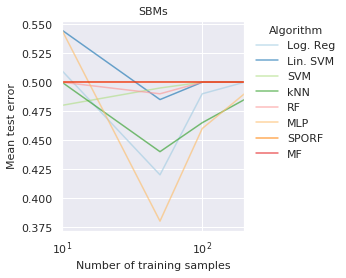

In [44]:
plot_data([write_path],names,title='SBMs')